In [1]:
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Fetch MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

C:\Users\Tori\anaconda3\envs\ML\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
#1 Try to build a classifier that achieves over 97% accuracy. 

In [3]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype('uint8') >= 7)
y_train_odd = (y_train.astype('uint8') % 2 == 1)
y_multilabel = np.array([y_train_large, y_train_odd]).T.astype('uint8')

knn_clf = KNeighborsClassifier()

In [4]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Note: Next chunks of code were converted to Markdown in order to cut down on processing time when restarting the kernel. The best model was pkled to avoid this cross-validation process in the future

# Fine-tune the Model

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3,5,7]},
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3,
                          scoring="neg_mean_squared_error",
                          return_train_score="True")
grid_search.fit(X_train, y_multilabel)
print(grid_search.best_estimator_)

# Evaluate on Test Set

final_model = grid_search.best_estimator_

In [16]:
# Compute average F1 score across all labels
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
import joblib
final_model = joblib.load('final_model.pkl')

y_train_knn_pred = cross_val_predict(final_model, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9774922346896824

import joblib

joblib.dump(final_model, "final_model.pkl")

#2 Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel. Then, for each image in the training set, create four shifted
copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.

In [5]:
from scipy.ndimage import shift

# for testing purposes
X_shift_up = shift(X_train, (1, 0))
X_shift_down = shift(X_train, (-1, 0))
X_shift_left = shift(X_train, (0, -1))
X_shift_right = shift(X_train, (0, 1))

In [6]:
def set_expand(data, x, y, cval=0):
    shift_up = shift(X_train, (y, 0))
    shift_down = shift(X_train, (-y, 0))
    shift_left = shift(X_train, (0, -x))
    shift_right = shift(X_train, (0, x))
    frames = [data, shift_right, shift_down, shift_left, shift_up]
    expanded_set = np.concatenate(frames, axis=0)
    
    return expanded_set

In [7]:
X_train_mod = set_expand(X_train, 1, 1)

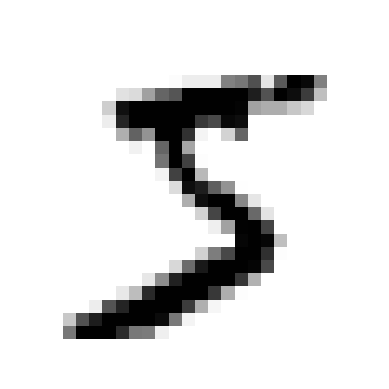

In [8]:
# Testing that the digits are correct
some_digit = X_train[0].astype('uint8')
plot_digit(some_digit)

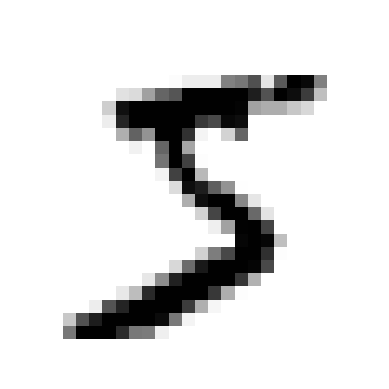

In [9]:
some_digit_mod = X_train_mod[0].astype('uint8')
plot_digit(some_digit_mod)

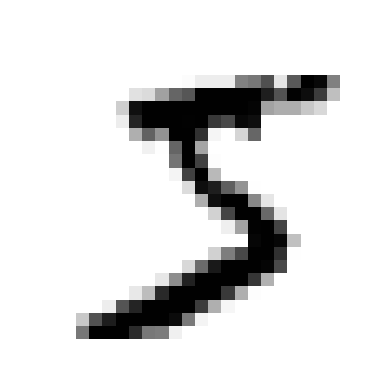

In [10]:
some_digit_right = X_shift_right[0].astype('uint8')
plot_digit(some_digit_right)

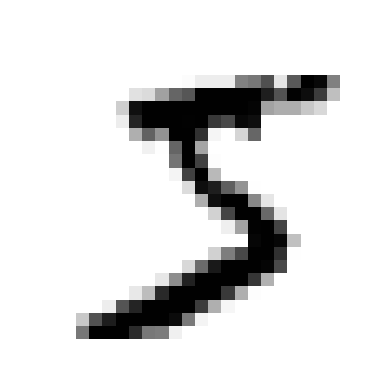

In [11]:
# Why blank? should be X_shift_right[0]
some_digit_up = X_train_mod[60000].astype('uint8')
plot_digit(some_digit_up)

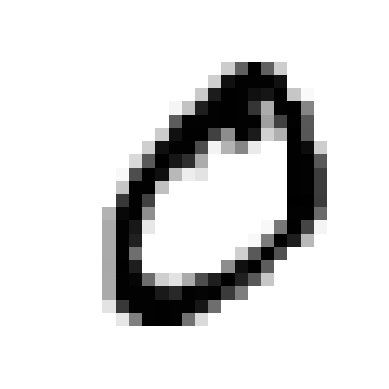

In [12]:
some_digit_up = X_train_mod[60001].astype('uint8')
plot_digit(some_digit_up)

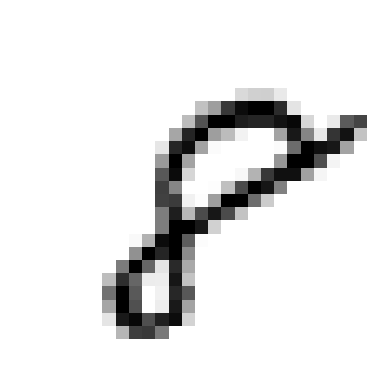

In [13]:
some_digit_up = X_shift_right[59999].astype('uint8')
plot_digit(some_digit_up)

In [14]:
import joblib
knn_clf_mod = joblib.load('final_model.pkl')
y_multilabel_mod = np.concatenate([y_multilabel,y_multilabel,y_multilabel,y_multilabel,y_multilabel], axis=0)
knn_clf_mod.fit(X_train_mod, y_multilabel_mod)

KNeighborsClassifier(n_neighbors=3)

In [15]:
from sklearn.metrics import f1_score 
from sklearn.model_selection import cross_val_predict

y_train_knn_mod_pred = cross_val_predict(knn_clf_mod, X_train_mod, y_multilabel_mod, cv=3) 
f1_score(y_multilabel_mod, y_train_knn_mod_pred, average="macro")

0.6179188165694258